# Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install modules

In [2]:
! pip install kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle
! pip install -q efficientnet
! kaggle --version

     |████████████████████████████████| 58 kB 4.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=fd720818bdaa11e9f635bcf05b332ce892f76254888cf5b8100c67c156c225ba
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 50 kB 4.0 MB/s 
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/

# Import kaggle json file

In [3]:
from google.colab import files
import os
if not os.path.isfile("kaggle.json"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
uploaded file "kaggle.json" with length 65 bytes


# Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from collections import Counter
% matplotlib inline
sns.set()


import math
from sklearn.model_selection import KFold

import PIL
import PIL.Image

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import efficientnet.tfkeras as efn

AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Read files

In [5]:
WORK_DIR = "/content/drive/MyDrive/kaggle/happy_whale"

submission_file_path = os.path.join(WORK_DIR, "./data/sample_submission.csv")
train_csv_file_path = os.path.join(WORK_DIR, "./data/train.csv")
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(submission_file_path)

concat_df = pd.concat([train_df['image'], test_df['image']])
image_name_to_image_id = dict((image_name, index) for index, image_name in enumerate(concat_df.unique()))
image_id_to_image_name = {v: k for k, v in image_name_to_image_id.items()}
image_ids = [image_name_to_image_id[image_name] for image_name in train_df['image']]
train_df['image_id'] = image_ids
individual_id_to_label = dict((i_id, index) for index, i_id in enumerate(train_df['individual_id'].unique()))
individual_id_to_label['new_individual'] = train_df["individual_id"].unique().shape[0]
label_to_individual_id = {v: k for k, v in individual_id_to_label.items()}
train_df['label'] = [individual_id_to_label[i_id] for i_id in train_df['individual_id']]
image_id_to_label = dict(zip(train_df["image_id"], train_df["label"]))

In [9]:
! mkdir ./happy_whale/tfrecord -p
! unzip  /content/drive/MyDrive/kaggle/happy_whale/tfrecord.zip -d ./happy_whale/tfrecord

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_c33e99f6c3aba8.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_0f1c63c7050d80.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_f7c9e6ebafd747.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/test_images_d816bb7558f620.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_efc9bf4041275c.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/test_images_d4880d9f41a258.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_beb0a5dde6d2cc.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/test_images_37926c1be2d21f.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/train_images_b2422ee114631f.tfrecord  
  inflating: ./happy_whale/tfrecord/happy_whale/tfrecord/test_images_8071834cfc5304.tfrecord  
  inflat

# Configures

In [12]:
IMAGE_SIZE = 512
SEED = 0
SHUFFLE_BUFFER_SIZE = 512
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

In [13]:
tfr_dir_path = os.path.join("./happy_whale/tfrecord/happy_whale", "tfrecord")
TRAIN_FILES = tf.io.gfile.glob(tfr_dir_path + "/train_images_*.tfrecord")
TEST_FILES = tf.io.gfile.glob(tfr_dir_path + "/test_images_*.tfrecord")
TRAIN_SIZE = int(0.8 * len(TRAIN_FILES))
VALIDATION_SIZE = int(len(TRAIN_FILES) - TRAIN_SIZE)
NEW_INDIVIDUAL_CLASSE = train_df["individual_id"].unique().shape[0]

# Read TF record

In [19]:
def decode_image(image_raw):
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

def parse_tfrecord(tfrecord):
    features = {'image_id': tf.io.FixedLenFeature([], tf.int64),
                'image_raw': tf.io.FixedLenFeature([], tf.string),
                'label': tf.io.FixedLenFeature([], tf.int64)}

    parsed_image_dataset = tf.io.parse_single_example(tfrecord, features)
    image_id = tf.cast(parsed_image_dataset['image_id'], tf.int32)
    image = decode_image(parsed_image_dataset['image_raw'])
    label = tf.cast(parsed_image_dataset['label'], tf.int32)
    return image_id, image, label

def load_dataset(filenames):
    raw_image_dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    image_dataset = raw_image_dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE) 
    
    return image_dataset

def check_format(image_id, image, label):
    return image_id


def arcface_format(image_id, image, label):
    return {'input/image': image, 'input/label': label}, label


def arcface_evaluation_format(image_id, image, label):
    return image

def arcface_test_format(image_id, image, label):
    return image_id, image


def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    
    return image


def get_check_dataset(filenames):
    ds = load_dataset(filenames)
    ds = ds.map(check_format, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

    
def get_training_dataset(filenames):
    ds = load_dataset(filenames)
    ds = ds.map(lambda image_id, image, label: (image, label))
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(lambda image, label: (augment(image), label), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda image, label: ({'input/image': image, 'input/label': label}, label))
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds
    
    
def get_validation_dataset(filenames):
    ds = load_dataset(filenames)
    ds = ds.map(arcface_format, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds
    

def get_evaluation_dataset(filenames):
    ds = load_dataset(filenames)
    ds = ds.map(arcface_evaluation_format, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


def get_test_dataset(filenames):
    ds = load_dataset(filenames)
    ds = ds.map(arcface_evaluation_format, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


In [15]:
kf = KFold(n_splits=5, random_state=91, shuffle=True)

train_filenames = []
val_filenames = []

for train_index, val_index in kf.split(TRAIN_FILES):
    train_filenames = [TRAIN_FILES[i] for i in train_index]
    val_filenames = [TRAIN_FILES[i] for i in val_index]
    break

In [16]:
check_train_ds = get_check_dataset(train_filenames)
check_val_ds = get_check_dataset(val_filenames)

In [17]:
%%time
train_image_id = [i.numpy() for i in check_train_ds]

CPU times: user 20min 28s, sys: 56.9 s, total: 21min 25s
Wall time: 6min 37s


In [20]:
train_ds_df = train_df.iloc[train_image_id].copy()
train_ds_df.head(20)

,image,species,individual_id,image_id,label
4741,17afe058d56675.jpg,humpback_whale,b42a2fda07df,4741,2965
16095,51378a51ea3830.jpg,bottlenose_dolpin,1f8d612d2fff,16095,7368
8545,2ae76e6b4ec5ad.jpg,killer_whale,5f6b2a178ecc,8545,3127
23486,768de9e9720985.jpg,bottlenose_dolphin,1191a41ee0f4,23486,185
44961,e1eefd9e83923d.jpg,false_killer_whale,e5c50e5f2e52,44961,486
8173,28e4ec97f4bb25.jpg,bottlenose_dolphin,8ca0a04df7a1,8173,1138
41690,d18fc00ba48dc2.jpg,dusky_dolphin,c96c0a13cb56,41690,13775
23868,7873bb0fdf23c5.jpg,humpback_whale,6c5ddc3852cc,23868,2526
2746,0de918c4481475.jpg,false_killer_whale,b90d49ab0905,2746,435
25568,81104020a95805.jpg,kiler_whale,46988583261a,25568,1036


In [21]:
%%time
val_image_id = [i.numpy() for i in check_val_ds]

CPU times: user 5min 12s, sys: 16.4 s, total: 5min 28s
Wall time: 1min 41s


In [22]:
val_ds_df = train_df.iloc[val_image_id].copy()
val_ds_df.head(20)

,image,species,individual_id,image_id,label
43136,d8b9bea685c9fc.jpg,killer_whale,9252fa90a2ba,43136,1088
21846,6e46d2aeb85ba8.jpg,minke_whale,37c7aba965a5,21846,47
38217,bfec2efdd45752.jpg,false_killer_whale,cca9869bbd74,38217,1656
50257,fc18aedf0eaabb.jpg,dusky_dolphin,75bac326bf0b,50257,15454
12885,40f114120ee82f.jpg,bottlenose_dolphin,0611c23e6914,12885,265
3590,1237345b93a0c5.jpg,killer_whale,9779b7473d54,3590,2378
4303,157593b205ce1d.jpg,false_killer_whale,9ab8c57f10bc,4303,460
21606,6cf22b5414d15d.jpg,spotted_dolphin,bbafe4010495,21606,9046
30066,974682d78c940a.jpg,beluga,184ca553804f,30066,3529
42848,d7347568019f38.jpg,blue_whale,93ab8d034380,42848,6666


In [23]:
train_ds_count = len(train_ds_df)
print("train data count: ", train_ds_count)

val_ds_count = len(val_ds_df)
print("valdation data count: ", val_ds_count)

train data count:  40826
valdation data count:  10207


In [24]:
train_ds = get_training_dataset(train_filenames)
val_ds = get_validation_dataset(val_filenames)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


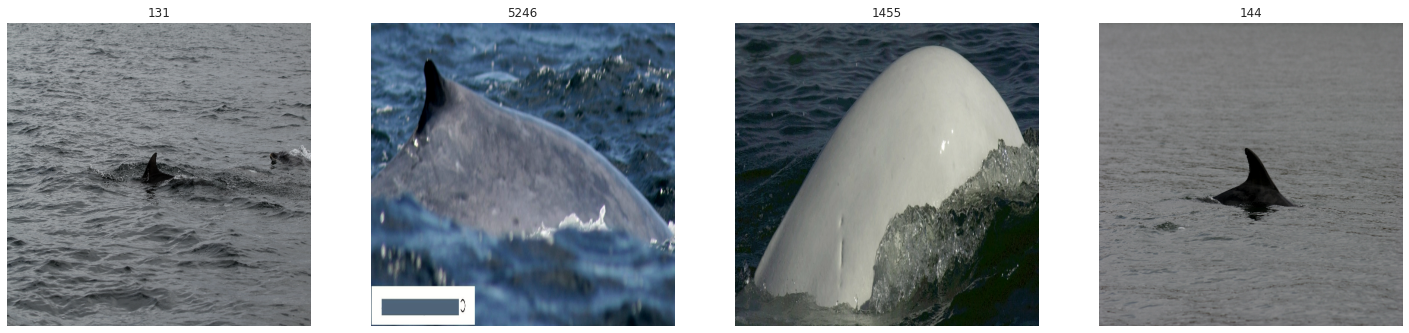

In [25]:
for (sample,label) in train_ds:
    imgs = sample['input/image']
    plt.figure(figsize=(25, 18))
    for j in range(len(label)):
        plt.subplot(1, len(label),j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(imgs[j])
    plt.show()
    break

In [ ]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False, ls_eps=0.0, **kwargs):
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

        
    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)


    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(tf.math.l2_normalize(X, axis=1), tf.math.l2_normalize(self.W, axis=0))
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
            
        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes), dtype=cosine.dtype)
        
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [ ]:
def create_model(input_shape,
                 n_classes,
                 dense_units=512,
                 dropout_rate=0.0,
                 scale=30,
                 margin=0.3):
    
    """
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    backbone = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    backbone = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False,
                                                                 weights='imagenet',
                                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
                                                                 
    x = preprocess_input(image)                                                             
    """
    
    backbone = efn.EfficientNetB5(include_top=False, weights='noisy-student')
    
    backbone.trainable=True

    pooling = tf.keras.layers.GlobalAveragePooling2D(name='head/pooling')
    dropout = tf.keras.layers.Dropout(dropout_rate, name='head/dropout')
    dense = tf.keras.layers.Dense(dense_units, name='head/dense')

    margin = ArcMarginProduct(n_classes=n_classes,
                              s=scale,
                              m=margin,
                              name='head/arc_margin',
                              dtype='float32')

    softmax = tf.keras.layers.Softmax(dtype='float32')

    image = tf.keras.layers.Input(input_shape, name='input/image')
    label = tf.keras.layers.Input((), name='input/label')

    
    x = backbone(image)
    x = pooling(x)
    x = dropout(x)
    embed = dense(x)
    x = margin([embed, label])
    outputs = softmax(x)
    
    model = tf.keras.Model(inputs=[image, label], outputs=outputs)
    embed_model = tf.keras.Model(inputs=image, outputs=embed)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

    return model, embed_model

In [ ]:
with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model, embed_model = create_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      n_classes=train_df["individual_id"].unique().shape[0],
                                      dense_units=512,
                                      dropout_rate=0.2,
                                      scale=30,
                                      margin=0.3)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input/image (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b5 (Functional)   (None, None, None,   28513520    ['input/image[0][0]']            
                                2048)                                                             
                                                                                                  
 head/pooling (GlobalAveragePoo  (None, 2048)        0           ['efficientnet-b5[0][0]']        
 ling2D)                                                                                    

In [ ]:
class ExpDecayScheduler:
    def __init__(self, warmup_lr_limit=0.001, warmup_epochs=4, lr_decay=0.9):
        self.warmup_lr_limit = warmup_lr_limit
        self.warmup_epochs = warmup_epochs
        self.lr_decay = lr_decay
        
        
    def __call__(self, epoch):
        epoch = max(epoch, 1)
        if epoch <= self.warmup_epochs:
            return self.warmup_lr_limit * epoch / self.warmup_epochs
        
        return self.warmup_lr_limit * (self.lr_decay ** (epoch - self.warmup_epochs))

    
class CosineDecayScheduler:
    def __init__(self, max_epochs, warmup_lr_limit=0.001, warmup_epochs=4):
        self.max_epochs = max_epochs
        self.warmup_lr_limit = warmup_lr_limit
        self.warmup_epochs = warmup_epochs


    def __call__(self, epoch):
        epoch = max(epoch, 1)
        if epoch <= self.warmup_epochs:
            return self.warmup_lr_limit * epoch / self.warmup_epochs
        
        epoch -= 1
        rad = math.pi * epoch / self.max_epochs
        weight = (math.cos(rad) + 1.0) / 2
        return self.warmup_lr_limit * weight

    
scheduler = ExpDecayScheduler(warmup_lr_limit=0.000005*BATCH_SIZE, warmup_epochs=4, lr_decay=0.9)  
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/kaggle/happy_whale/model/model_weights.h5', 
                                             monitor='val_loss', 
                                             verbose=0, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='min', 
                                             save_freq='epoch')

In [ ]:
# model_path = os.path.join(WORK_DIR, "model/model_weights.h5")
# model.load_weights(model_path)

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          verbose=1,
          callbacks=[lr_scheduler_callback, model_checkpoint],
          steps_per_epoch=(train_ds_count//BATCH_SIZE),
          validation_steps=(val_ds_count//BATCH_SIZE))

Epoch 1/30
10206/10206 [==============================] - 5758s 564ms/step - loss: 13.9525 - sparse_categorical_accuracy: 7.3486e-05 - sparse_top_k_categorical_accuracy: 2.4495e-04 - val_loss: 14.5476 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 2.9400e-04 - lr: 5.0000e-06
Epoch 2/30
10206/10206 [==============================] - 5738s 562ms/step - loss: 13.3325 - sparse_categorical_accuracy: 2.9394e-04 - sparse_top_k_categorical_accuracy: 8.8183e-04 - val_loss: 13.8316 - val_sparse_categorical_accuracy: 3.9200e-04 - val_sparse_top_k_categorical_accuracy: 8.8201e-04 - lr: 5.0000e-06
Epoch 3/30
 2045/10206 [=====>........................] - ETA: 1:13:29 - loss: 12.9197 - sparse_categorical_accuracy: 6.1125e-04 - sparse_top_k_categorical_accuracy: 0.0018

In [ ]:
model_path = os.path.join(WORK_DIR, "model/model_weights.h5")
model.load_weights(model_path)

In [ ]:
eval_ds_df = val_ds_df.copy()

ids_set = set([i_id for i_id in train_ds_df['individual_id'].unique()])
eval_ds_df.loc[~eval_ds_df.individual_id.isin(ids_set),'individual_id'] = 'new_individual'
eval_ds_df.loc[~eval_ds_df.individual_id.isin(ids_set),'label'] = NEW_INDIVIDUAL_CLASSE
eval_ds_df.head(20)

In [ ]:
eval_train_ds = get_evaluation_dataset(train_filenames)
eval_val_ds = get_evaluation_dataset(val_filenames)

In [ ]:
train_embeddings = embed_model.predict(eval_train_ds, verbose=1)
val_embeddings = embed_model.predict(eval_val_ds, verbose=1)

In [ ]:
from sklearn.neighbors import NearestNeighbors
eval_nn = NearestNeighbors(n_neighbors=150, metric='cosine')
eval_nn.fit(train_embeddings)

In [ ]:
%%time
eval_distances, eval_indices = eval_nn.kneighbors(val_embeddings, n_neighbors=150, return_distance=True)

In [ ]:
eval_indices_list = eval_indices.tolist()
eval_confidences_list = (1 - eval_distances).tolist()

eval_ds_df['prediction_labels'] = None
eval_ds_df['confidence'] = None

for i, (eval_inds, confs) in enumerate(zip(eval_indices_list, eval_confidences_list)):
    prediction_labels = []
    confidence = []
    
    for eval_ind, conf in zip(eval_inds, confs):
        pred = train_ds_df.at[train_ds_df.index[eval_ind], 'label']
        
        if not (pred in prediction_labels):
            prediction_labels.append(pred)
            confidence.append(conf)
            
            eval_ds_df.at[eval_ds_df.index[i], 'prediction_labels'] = prediction_labels
            eval_ds_df.at[eval_ds_df.index[i], 'confidence'] = confidence
            
            if len(prediction_labels) == 5:
                break

In [ ]:
eval_ds_df.head()

In [ ]:
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

In [ ]:
thresholds = np.linspace(0, 1.0, 11)
best_threshold = 0
best_cv = 0


for th in thresholds:
    temp_val = eval_ds_df.copy()
    
    for i, (confs, preds) in enumerate(zip(temp_val['confidence'], temp_val['prediction_labels'])):
        temp_preds = preds
        
        for j, conf in enumerate(confs):
            if conf <= th:
                temp_preds.insert(j, NEW_INDIVIDUAL_CLASSE)
                temp_preds.pop()
                break
            
        temp_val.at[temp_val.index[i], 'prediction_labels'] = temp_preds
        

    eval_ds_df[f'threshold_{th}'] = None
    for i, (label, preds) in enumerate(zip(temp_val['label'], temp_val['prediction_labels'])):
        eval_ds_df.at[temp_val.index[i], f'threshold_{th}'] = map_per_image(label, preds)
  
    cv = eval_ds_df[f'threshold_{th}'].mean()
    print(f"Threshold: {th}, CV: {cv}")
    
    if cv > best_cv:
        best_threshold = th
        best_cv = cv

        
print("Best threshold", best_threshold)
print("Best cv", best_cv)

In [ ]:
eval_ds_df

In [ ]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
threshold_df = eval_ds_df[[f'threshold_{th}' for th in thresholds]]
eval_ds_df['is_new_individual'] = eval_ds_df['individual_id']=='new_individual'
print(eval_ds_df.is_new_individual.value_counts().to_dict())
threshold_df

In [ ]:
eval_scores = pd.DataFrame(thresholds, columns=['threshold'])
eval_scores['adjusted_cv'] = 0
adjusted_cv = threshold_df[eval_ds_df['is_new_individual']].mean() * 0.1 + threshold_df[~eval_ds_df['is_new_individual']].mean() * 0.9
eval_scores['adjusted_cv'] = [i for i in adjusted_cv]
best_threshold_adjusted = eval_scores['threshold'].iloc[eval_scores['adjusted_cv'].idxmax()]
print("best_threshold",best_threshold_adjusted)
eval_scores

In [ ]:
test_ds_df = test_df.copy()
test_ds_df.head()

In [ ]:
concat_train_embeddings = np.concatenate([train_embeddings, val_embeddings])
concat_train_embeddings.shape

In [ ]:
concat_train_ds_df = pd.concat([train_ds_df, val_ds_df])
concat_train_ds_df.shape

In [ ]:
test_nn = NearestNeighbors(n_neighbors=150, metric='cosine')
test_nn.fit(concat_train_embeddings)

In [ ]:
N_TRAIN_DATA = 51033
N_TEST_DATA = 27956
N_CLASSES = 15587
NEW_INDIVIDUAL_CLASSE = 15587

In [ ]:
%%time
check_test_ds = get_check_dataset(TEST_FILES)
test_image_id = [i.numpy() - N_TRAIN_DATA for i in check_test_ds]

In [ ]:
test_image_id[:10]

In [ ]:
test_ds_df = test_ds_df.reindex(test_image_id)
test_ds_df.head()

In [ ]:
test_ds = get_test_dataset(TEST_FILES)
test_embeddings = embed_model.predict(test_ds, verbose=1)

In [ ]:
%%time
test_distances, test_indices = test_nn.kneighbors(test_embeddings, n_neighbors=150, return_distance=True)

In [ ]:
test_indices_list = test_indices.tolist()
test_confidences_list = (1 - test_distances).tolist()

test_ds_df['prediction_labels'] = None
test_ds_df['confidence'] = None

for i, (test_inds, confs) in enumerate(zip(test_indices_list, test_confidences_list)):
    prediction_labels = []
    confidence = []
    
    for test_ind, conf in zip(test_inds, confs):
        pred = concat_train_ds_df.at[concat_train_ds_df.index[test_ind], 'label']
        
        if not (pred in prediction_labels):
            prediction_labels.append(pred)
            confidence.append(conf)
            
            test_ds_df.at[test_ds_df.index[i], 'prediction_labels'] = prediction_labels
            test_ds_df.at[test_ds_df.index[i], 'confidence'] = confidence
            
            if len(prediction_labels) == 5:
                break

In [ ]:
test_ds_df.head()

In [ ]:
test_ds_df = test_ds_df.reindex([i for i in range(N_TEST_DATA)])
test_ds_df.head()

In [ ]:
predictions = [None] * N_TEST_DATA

for i, pred_labels in enumerate(test_ds_df['prediction_labels']):
    row = []
    
    for pred_label in pred_labels:
        row.append(label_to_individual_id[pred_label])
        
    predictions[i] = " ".join(row)

In [ ]:
test_ds_df['predictions'] = predictions
_ = test_ds_df.pop('prediction_labels')
_ = test_ds_df.pop('confidence')

test_ds_df.head()

In [ ]:
test_ds_df.to_csv(os.path.join(WORK_DIR, "result/submission.csv"), index=False)